# Region masks

### Australia state and territory mask

State boundaries from ABS: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files

In [1]:
import xarray as xr
import geopandas
import regionmask

Load single instance of ERA5 grid
This is to be used with `regionmask` to create our mask

In [2]:
era_template = xr.open_dataset(
    "/g/data/rt52/era5/single-levels/monthly-averaged/2t/2010/2t_era5_moda_sfc_20100101-20100131.nc"
)

Load geometries

In [3]:
state_gpd = geopandas.read_file(
    "/g/data/w42/dr6273/work/data/ABS/STE_2021_AUST_SHP_GDA2020/STE_2021_AUST_GDA2020.shp"
)

In [4]:
state_gpd.head()

,STE_CODE21,STE_NAME21,CHG_FLAG21,CHG_LBL21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,1,New South Wales,0,No change,AUS,Australia,8.007977e+05,http://linked.data.gov.au/dataset/asgsed3/STE/1,"MULTIPOLYGON (((159.06230 -31.50886, 159.06218..."
1,2,Victoria,0,No change,AUS,Australia,2.274962e+05,http://linked.data.gov.au/dataset/asgsed3/STE/2,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,3,Queensland,0,No change,AUS,Australia,1.730171e+06,http://linked.data.gov.au/dataset/asgsed3/STE/3,"MULTIPOLYGON (((142.53140 -10.68301, 142.53072..."
3,4,South Australia,0,No change,AUS,Australia,9.842314e+05,http://linked.data.gov.au/dataset/asgsed3/STE/4,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,5,Western Australia,0,No change,AUS,Australia,2.526632e+06,http://linked.data.gov.au/dataset/asgsed3/STE/5,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."


In [5]:
list(state_gpd["STE_NAME21"])

['New South Wales',
 'Victoria',
 'Queensland',
 'South Australia',
 'Western Australia',
 'Tasmania',
 'Northern Territory',
 'Australian Capital Territory',
 'Other Territories',
 'Outside Australia']

Create mask

In [6]:
def create_mask(gpd_df, template_ds, boundary=None, lon_name='longitude', lat_name='latitude'):
    """
    Create mask from shapefiles and a template xarray dataArray or dataset.
    """
    mask = regionmask.mask_3D_geopandas(
        gpd_df,
        template_ds[lon_name],
        template_ds[lat_name]
    )
    
    if lon_name != 'lon':
        mask = mask.rename({lon_name: 'lon'})
    if lat_name != 'lat':
        mask = mask.rename({lat_name: 'lat'})
        
    if isinstance(boundary, list):
        mask = mask.sel(
            lon=slice(boundary[0], boundary[1]),
            lat=slice(boundary[2], boundary[3])
        )
        
    return mask

In [7]:
mask = create_mask(
    state_gpd.iloc[:-2],
    era_template.sel(longitude=slice(108, 158), latitude=slice(-8, -45)),
    None
)

In [8]:
mask["region"] = ["NSW", "VIC", "QLD", "SA", "WA", "TAS", "NT", "ACT"]

Combine ACT and NSW, and create a new NEM region

In [9]:
NSW2 = mask.sel(region=["NSW", "ACT"]).sum("region")

In [10]:
NEM = mask.sel(region=["NSW", "VIC", "QLD", "SA", "TAS", "ACT"]).sum("region")

In [11]:
nem_mask = xr.concat([
    mask.sel(region=["VIC", "QLD", "SA", "TAS"]),
    NSW2.expand_dims({"region": ["NSW"]}),
    NEM.expand_dims({"region": ["NEM"]})
],
    dim="region"
)

In [12]:
nem_mask = nem_mask.sel(region=["NEM", "NSW", "VIC", "QLD", "SA", "TAS"])

In [13]:
nem_mask["region"]

<xarray.DataArray 'region' (region: 6)>
array(['NEM', 'NSW', 'VIC', 'QLD', 'SA', 'TAS'], dtype=object)
Coordinates:
  * region   (region) object 'NEM' 'NSW' 'VIC' 'QLD' 'SA' 'TAS'

In [51]:
nem_mask.to_dataset(name="mask").to_netcdf("/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_state_mask.nc")

Population by state

Load population file

In [54]:
pop = xr.open_dataset(
    "/g/data/w42/dr6273/work/data/ABS/ABS_population_density/population_density_era5_grid.nc"
)["population_density"]

In [84]:
pop.sum()

<xarray.DataArray 'population_density' ()>
array(25883452., dtype=float32)

In [57]:
nem_pop = nem_mask * pop

In [88]:
nem_pop.to_dataset(name="population_density").to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_population_density_state_mask.nc"
)

Repeat for discrete and log masks

In [14]:
for b in [10, 100, 1000]:
    discrete = xr.open_dataset(
        "/g/data/w42/dr6273/work/data/ABS/ABS_population_density/population_density_era5_grid_discrete_"+str(b)+".nc"
    )["population_bins_"+str(b)]
    nem_pop = nem_mask * discrete
    nem_pop.to_dataset(name="population_bins_"+str(b)).to_netcdf(
        "/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_population_density_state_mask_discrete_"+str(b)+".nc"
    )

In [19]:
log = xr.open_dataset(
    "/g/data/w42/dr6273/work/data/ABS/ABS_population_density/population_density_era5_grid_log.nc"
)["log_population_density"]

nem_pop = nem_mask * log
nem_pop = nem_pop.where(nem_pop >= 0)

nem_pop.to_dataset(name="log_population_density").to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_population_density_state_mask_log.nc"
)

### Europe mask

In [104]:
eu = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

In [105]:
eu_template = era_template.sel(longitude=slice(-25, 37), latitude=slice(72, 33))

In [106]:
mask = eu.mask_3D(eu_template["longitude"], eu_template["latitude"])

In [107]:
mask = mask.rename({"latitude": "lat", "longitude": "lon"})

In [108]:
mask.names

<xarray.DataArray 'names' (region: 50)>
array(['Russia', 'Norway', 'Greenland', 'France', 'Israel', 'Lebanon',
       'Tunisia', 'Algeria', 'Syria', 'Sweden', 'Belarus', 'Ukraine',
       'Poland', 'Austria', 'Hungary', 'Moldova', 'Romania', 'Lithuania',
       'Latvia', 'Estonia', 'Germany', 'Bulgaria', 'Greece', 'Turkey',
       'Albania', 'Croatia', 'Switzerland', 'Luxembourg', 'Belgium',
       'Netherlands', 'Portugal', 'Spain', 'Ireland', 'Italy', 'Denmark',
       'United Kingdom', 'Iceland', 'Slovenia', 'Finland', 'Slovakia',
       'Czechia', 'N. Cyprus', 'Cyprus', 'Morocco', 'Libya',
       'Bosnia and Herz.', 'North Macedonia', 'Serbia', 'Montenegro',
       'Kosovo'], dtype='<U16')
Coordinates:
  * region   (region) int64 18 21 22 43 76 77 81 ... 162 164 170 171 172 173 174
    abbrevs  (region) <U3 'RUS' 'N' 'GL' 'F' 'IS' ... 'BiH' 'NM' 'RS' 'ME' 'KO'
    names    (region) <U16 'Russia' 'Norway' ... 'Montenegro' 'Kosovo'

In [109]:
names = [ # Chosen to match those available with demand data
    "Austria", "Bosnia and Herz.", "Belgium", "Bulgaria", "Cyprus", "Czechia",
    "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Croatia",
    "Hungary", "Iceland", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg",
    "Montenegro", "Netherlands", "North Macedonia", "Norway", "Poland", "Portugal",
    "Romania", "Serbia", "Slovenia", "Slovakia", "Spain", "Sweden", "Switzerland",
    "United Kingdom"
]

In [110]:
abbrevs = [ # Chosen to match demand country codes
    "AT", "BA", "BE", "BG", "CY", "CZ",
    "DK", "EE", "FI", "FR", "DE", "GR", "HR",
    "HU", "IS", "IE", "IT", "LV", "LI", "LU",
    "ME", "NL", "MK", "NO", "PL", "PT",
    "RO", "RS", "SI", "SK", "ES", "SE", "CH",
    "GB"
]

In [111]:
mask = mask.swap_dims({"region": "names"})

In [112]:
mask = mask.sel(names=names)

In [113]:
mask["names"] = abbrevs

In [114]:
mask = mask.drop(["region", "abbrevs"]).rename({"names": "region"})

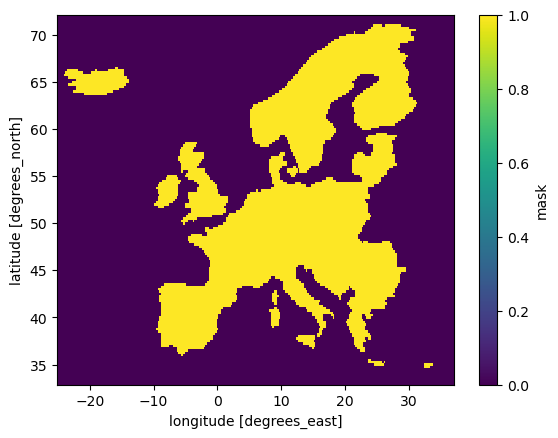

In [116]:
mask.sum("region").plot()

In [117]:
mask.to_dataset(name="mask").to_netcdf("/g/data/w42/dr6273/work/projects/Aus_energy/data/EU_mask.nc")

Population by state

Load population file

In [118]:
pop = xr.open_dataset(
    "/g/data/w42/dr6273/work/data/SEDAC/population_counts_era5_grid.nc"
)["population_count"]

In [119]:
pop = pop.sel(lat=eu_template["latitude"].values, lon=eu_template["longitude"].values)

In [120]:
eu_pop = mask * pop

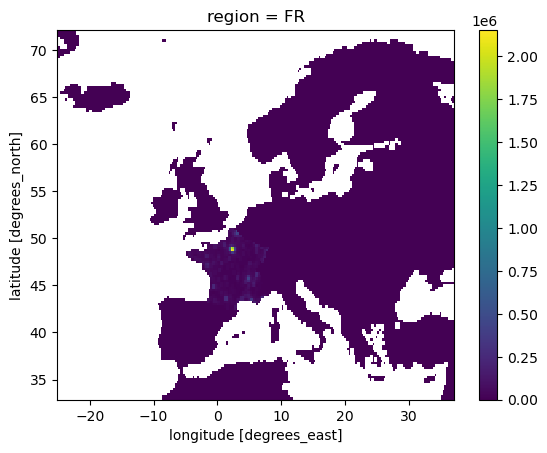

In [121]:
eu_pop.sel(region="FR").plot()

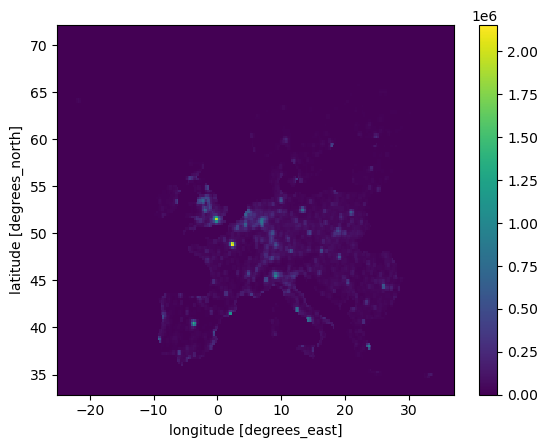

In [122]:
eu_pop.sum("region").plot()

In [124]:
eu_pop.to_dataset(name="population_count").to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/EU_population_count_mask.nc"
)

Repeat for discrete and log masks

In [125]:
for b in [10, 100, 1000, 100000]:
    discrete = xr.open_dataset(
        "/g/data/w42/dr6273/work/data/SEDAC/population_counts_era5_grid_discrete_"+str(b)+"_EU.nc"
    )["population_bins_"+str(b)]
    eu_pop = mask * discrete
    eu_pop.to_dataset(name="population_count_"+str(b)).to_netcdf(
        "/g/data/w42/dr6273/work/projects/Aus_energy/data/EU_population_count_mask_discrete_"+str(b)+".nc"
    )

In [126]:
log = xr.open_dataset(
    "/g/data/w42/dr6273/work/data/SEDAC/population_counts_era5_grid_log_EU.nc"
)["log_population_count"]

eu_pop = mask * log
eu_pop = eu_pop.where(eu_pop >= 0)

eu_pop.to_dataset(name="log_population_count").to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/EU_population_count_mask_log.nc"
)